In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Часть I: О теореме Байеса

### 1.
Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!

Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.


#### Ответ:
* А - редкая группа крови у подсудимого
* B - подсудимый виновен

Прокурор оценил $P(A | \overline B)$, а должен был $P(B | A) = \frac{P(B)P(A | B)}{P(A)}$

Он заявил, что $P(A | \overline B)=0.01$ - у подсудимого именно такая группа крови, если он невиновен 

а значит $P(\overline A | \overline B)=0.99$ - предлагаю осудить

поближе рассмотрим $P(B | A)$:

заметим, что $P(A | B)=1$

$$P(B | A) = \frac{P(B)P(A | B)}{P(B)P(A | B) + P(A | \overline B)P(\overline B)} = \frac{P(B)}{P(B) + 0.01(1 - P(B))}$$

где P(B) - арприорная вероятность того, что подозреваемый убийца 

Попробуем повизуализировать постериорную вероятность при некоторых значениях априорной

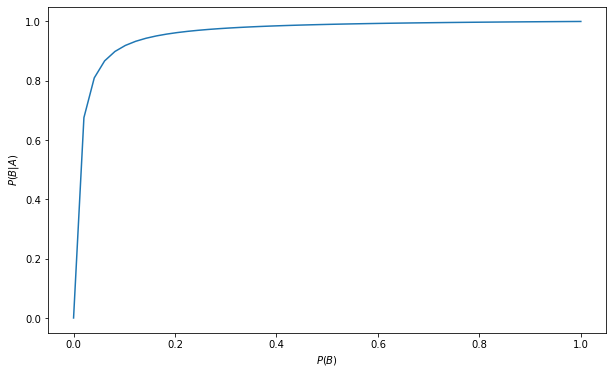

In [2]:
def get_posterior(p_b):
    return p_b / ( 0.99 * p_b + .01)

p_b = np.linspace(0, 1, 50)
plt.figure(figsize=(10, 6))
plt.plot(p_b, get_posterior(p_b))
plt.xlabel('$P(B)$')
plt.ylabel('$P(B|A)$')
plt.show()

In [3]:
print(f"к слову при P(B)=0.5, P(B|A)={get_posterior(.5):.3}")

к слову при P(B)=0.5, P(B|A)=0.99


## 2.
Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?


#### Ответ:

In [4]:
get_posterior(.01)

0.5025125628140703

Он указал априорную вероятность, но даже при такой крохотной вероятности условие делает априорную достаточно большой

Похоже, что юрист и сам не разбирается или же очень хорошо делает свою работу

### 3.
Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.

Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).

Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?


#### Ответ:

* A - положительный тест
* B - болен

* $P(A | \overline B) - fp$
* $P(\overline A | B) - fn$

* $P(\overline A | \overline B) = 1 - P(A | \overline B)$
* $P( A |  B) = 1 - P(\overline A | B)$

$$P(B | A) = \frac{P(B)P(A|B)}{P(A)}=\frac{0.01(1-fn)}{0.01(1-fn)+0.99fp}$$

$$P(B | \overline A)=\frac{P(B)(\overline A | B)}{P(\overline A)}=\frac{0.01fn}{0.01fn+0.99(1-fp)}$$

In [5]:
def get_posterior_proba(fp, fn, positive_test):
    if positive_test:
        return 0.01 * (1 - fn) / (0.01 * (1 - fn) + 0.99 * fp) # P(B|A)
    else:
        return 0.01 * fn / (0.01 * fn + 0.99 * (1 - fp)) # P(B|-A)   

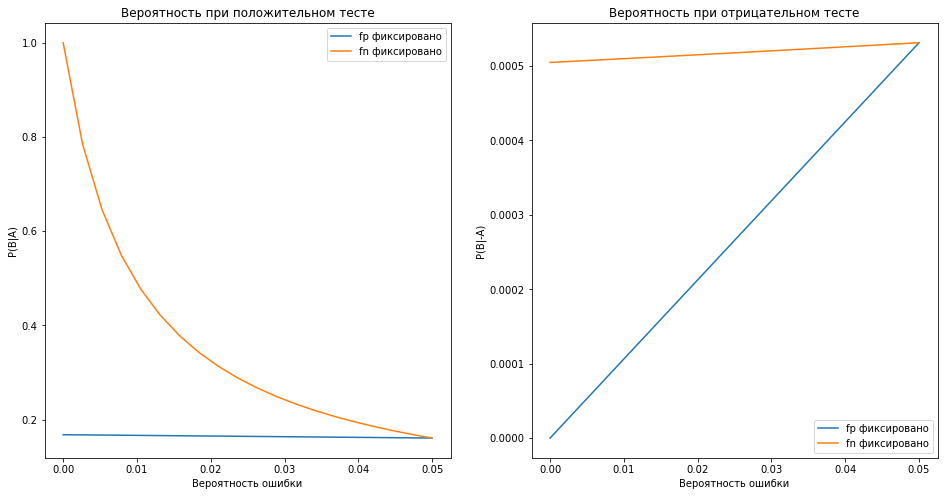

In [6]:
errors = np.linspace(0, 0.05, 20)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

proba = get_posterior_proba(0.05, errors, True)
ax1.plot(errors, proba, label="fp фиксировано")
proba = get_posterior_proba(errors, 0.05, True)
ax1.plot(errors, proba, label="fn фиксировано")
ax1.set_xlabel("Вероятность ошибки")
ax1.set_ylabel("P(B|A)")
ax1.set_title("Вероятность при положительном тесте")
ax1.legend()

proba = get_posterior_proba(0.05, errors, False)
ax2.plot(errors, proba, label="fp фиксировано")
proba = get_posterior_proba(errors, 0.05, False)
ax2.plot(errors, proba, label="fn фиксировано")
ax2.set_title("Вероятность при отрицательном тесте")
ax2.set_xlabel("Вероятность ошибки")
ax2.set_ylabel("P(B|-A)")
ax2.legend()

plt.show()

Если смотреть на график как бы слева направо, то $P(B|A)$ должна расти, а $P(B|\overline A)$ должна падать

А как мы можем наблюдать из графика при снижении fp точность растет экспоненциально, т.е. гораздо быстрее при fn, тогда я бы посоветовал врачам сконцентривать внимание именно на этом, к тому же, уменьшая fp, мы уменьшаем ложные срабатывания и нагрузку на врачей 

## Часть II: О линейной регрессии

### 1.
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.


In [7]:
data = pd.read_csv("owid-covid-data.csv")

In [8]:
df = data[data['location'] == 'Russia'].copy()

In [9]:
df.date = pd.to_datetime(df.date)

In [10]:
df = df[(df.date >= pd.to_datetime('2020-03-03')) & (df.date <= pd.to_datetime('2020-03-03') + timedelta(70))]
df = df[['date', 'total_cases', 'new_cases']]

In [11]:
df.new_cases[df.new_cases == 0] = 1

In [12]:
df.head()

,date,total_cases,new_cases
52760,2020-03-03,3.0,1.0
52761,2020-03-04,3.0,1.0
52762,2020-03-05,4.0,1.0
52763,2020-03-06,13.0,9.0
52764,2020-03-07,13.0,1.0


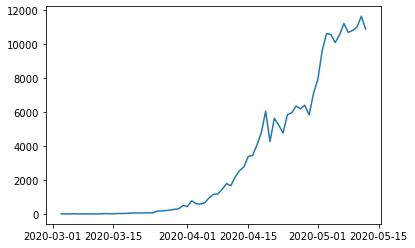

In [13]:
plt.plot(df.date, df.new_cases)

### 2.
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

#### a. 
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ *exp(линейная функция от x)*, где x — номер текущего дня.

In [14]:
df.head()

,date,total_cases,new_cases
52760,2020-03-03,3.0,1.0
52761,2020-03-04,3.0,1.0
52762,2020-03-05,4.0,1.0
52763,2020-03-06,13.0,9.0
52764,2020-03-07,13.0,1.0


In [15]:
X = np.arange(df.shape[0])
y_total = df.total_cases
y_new = df.new_cases

In [16]:
days = 50
X_train = X[:days]
y_train_total = y_total[:days]
y_train_new = y_new[:days]
X_test = X[days:]
y_test_total = y_total[days:]
y_test_new = y_new[days:]

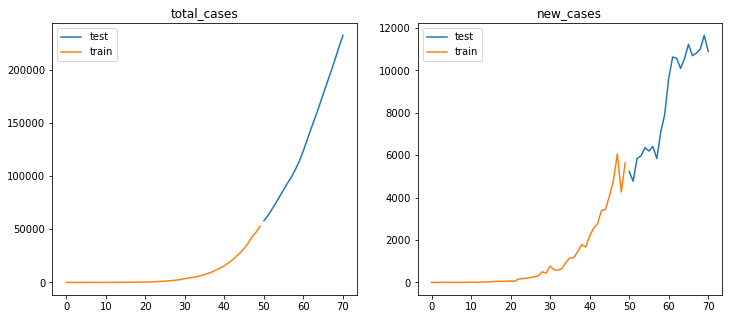

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(X_test, y_test_total, label='test')
ax1.plot(X_train, y_train_total, label='train')
ax1.set_title('total_cases')
ax1.legend()

ax2.plot(X_test, y_test_new, label='test')
ax2.plot(X_train, y_train_new, label='train')
ax2.set_title('new_cases')
ax2.legend()
plt.show()

In [18]:
y_train_total_ln = np.log(y_train_total)
y_test_total_ln = np.log(y_test_total)

y_train_new_ln = np.log(y_train_total)
y_test_new_ln = np.log(y_test_total)

In [19]:
def add_ones(matr):
    return np.stack([np.ones(matr.shape[0]), matr], axis=-1)

In [20]:
X = add_ones(X)
X_train = add_ones(X_train)
X_test = add_ones(X_test)

In [21]:
def alpha_search(X_train, y_train, X_test, y_test):
    alphas = np.arange(500, 7000, 250)
    best_alpha = 0
    best_train = 1e18
    for alpha in alphas:
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X_train, np.log(y_train))
        train_error = np.sqrt(mean_squared_error(y_train, np.exp(model.predict(X_train))))
        test_error = np.sqrt(mean_squared_error(y_test, np.exp(model.predict(X_test))))
        print(f'alpha = {alpha}, train_error={train_error}, test_error={test_error}')
    
        if best_train > train_error:
            best_train = train_error
            best_alpha = alpha
            
    return best_alpha

In [22]:
best_alpha_total = alpha_search(X_train, y_train_total, X_test, y_test_total)
print(f"\nbest_alpha_total = {best_alpha_total}")

alpha = 500, train_error=32186.99943952946, test_error=13318094.697362488
alpha = 750, train_error=29232.61165318561, test_error=12187267.723204404
alpha = 1000, train_error=26372.727182352144, test_error=11076909.849090451
alpha = 1250, train_error=23688.75830726963, test_error=10046674.97172842
alpha = 1500, train_error=21195.546154736632, test_error=9107546.795133244
alpha = 1750, train_error=18890.068958488842, test_error=8257415.047336174
alpha = 2000, train_error=16763.86011740553, test_error=7490120.964148833
alpha = 2250, train_error=14807.191432864367, test_error=6798400.884730203
alpha = 2500, train_error=13010.812246644293, test_error=6174976.763524618
alpha = 2750, train_error=11366.879258627438, test_error=5612977.769037551
alpha = 3000, train_error=9869.670981451063, test_error=5106091.914749594
alpha = 3250, train_error=8516.37720022218, test_error=4648601.193020122
alpha = 3500, train_error=7308.156644907556, test_error=4235365.171800395
alpha = 3750, train_error=6251.5

In [23]:
best_alpha_new = alpha_search(X_train, y_train_new, X_test, y_test_new)
print(f"\nbest_alpha_new = {best_alpha_new}")

alpha = 500, train_error=1508.4887253701793, test_error=278443.04493564466
alpha = 750, train_error=1350.0777702972016, test_error=257314.31217717947
alpha = 1000, train_error=1203.1390933849693, test_error=237655.05087683216
alpha = 1250, train_error=1068.5682057427036, test_error=219548.6112429199
alpha = 1500, train_error=946.749271888831, test_error=202919.63136251605
alpha = 1750, train_error=838.1439583910358, test_error=187658.27524007313
alpha = 2000, train_error=743.470662120369, test_error=173650.55872681178
alpha = 2250, train_error=663.752607217779, test_error=160787.50348348176
alpha = 2500, train_error=600.2313862520417, test_error=148967.99048000973
alpha = 2750, train_error=554.0757373783599, test_error=138099.408857616
alpha = 3000, train_error=525.8680924055556, test_error=128097.46441870782
alpha = 3250, train_error=515.0561225850792, test_error=118885.66489258363
alpha = 3500, train_error=519.7485112339822, test_error=110394.69587174036
alpha = 3750, train_error=537

In [24]:
model_total = Ridge(alpha=best_alpha_total, fit_intercept=False)
model_total.fit(X_train, y_train_total_ln)

model_new = Ridge(alpha=best_alpha_new, fit_intercept=False)
model_new.fit(X_train, y_train_new_ln)

Ridge(alpha=3250, fit_intercept=False)

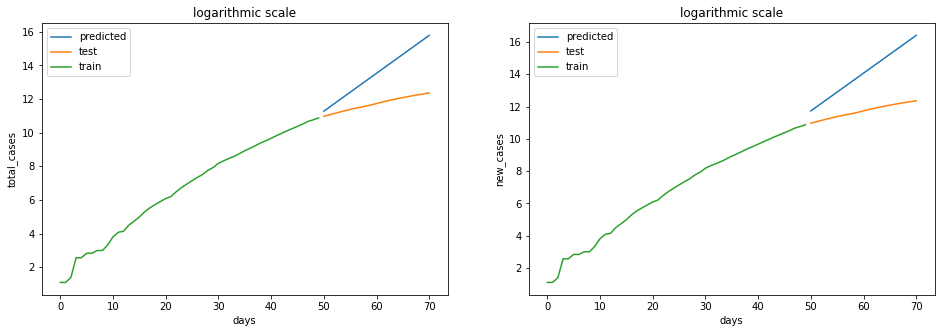

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(X_test[:, 1], model_total.predict(X_test), label='predicted')
ax1.plot(X_test[:, 1], y_test_total_ln, label='test')
ax1.plot(X_train[:, 1], y_train_total_ln, label='train')
ax1.set_xlabel('days')
ax1.set_ylabel('total_cases')
ax1.legend()
ax1.set_title('logarithmic scale')

ax2.plot(X_test[:, 1], model_new.predict(X_test), label='predicted')
ax2.plot(X_test[:, 1], y_test_new_ln, label='test')
ax2.plot(X_train[:, 1], y_train_new_ln, label='train')
ax2.set_xlabel('days')
ax2.set_ylabel('new_cases')
ax2.legend()
ax2.set_title('logarithmic scale')

plt.show()

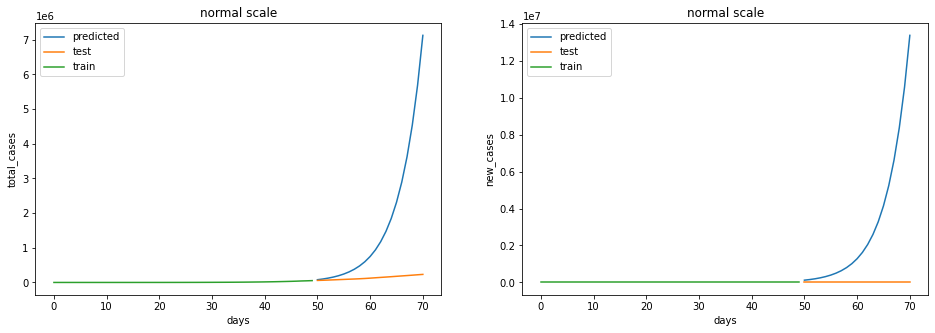

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(X_test[:, 1], np.exp(model_total.predict(X_test)), label='predicted')
ax1.plot(X_test[:, 1], y_test_total, label='test')
ax1.plot(X_train[:, 1], y_train_total, label='train')
ax1.set_xlabel('days')
ax1.set_ylabel('total_cases')
ax1.legend()
ax1.set_title('normal scale')

ax2.plot(X_test[:, 1], np.exp(model_new.predict(X_test)), label='predicted')
ax2.plot(X_test[:, 1], y_test_new_ln, label='test')
ax2.plot(X_train[:, 1], y_train_new_ln, label='train')
ax2.set_xlabel('days')
ax2.set_ylabel('new_cases')
ax2.legend()
ax2.set_title('normal scale')

plt.show()

#### b.
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Eсли взять априорное распределение как $p(w) = \mathcal{N}(w|\mu_0, \Sigma_0)$, то апостериорное распределение имеет вид:
$$
p(w|D) = \mathcal{N}(w| \mu_N, \Sigma_N),
$$
где $\Sigma_N = (\Sigma_0^{-1} + \frac{1}{\sigma^2}X^T X)^{-1}$, $\mu_N = \Sigma_N(\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}X^T \ln{y})$, $\sigma^2$ - дисперсия шума в данных.  

Априорное распределение гребневой регрессии:

$$p(w)=\mathcal{N}(w|0, \sigma_0^2I)$$

Т. к. регуляяризатор $\alpha=\frac{\sigma^2}{\sigma_0^2}$, получаем $\sigma_0^2=\frac{\sigma^2}{\alpha}$.

In [28]:
noise = np.std(np.array(y_train_total_ln) - model_total.predict(X_train))
noise

0.5227328176468423

In [29]:
s = noise ** 2 / best_alpha_total
s

5.4649919729001385e-05

In [30]:
def bayes(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), np.array(y)))
    return mu_n, sigma_n


def get_mu_sigma(X_train, y_train, s, noise):
    mu_0 = np.zeros(X_train.shape[1])
    sigma_0 = s * np.eye(X_train.shape[1])
    mu_n, sigma_n = bayes(mu_0, sigma_0, X_train, y_train, noise)
    return mu_n, sigma_n

In [31]:
mu, sigma = get_mu_sigma(X_train, np.log(y_train_total), s, noise)
print("mu =", mu)
print("sigma =", sigma)

mu = [0.01148612 0.22525575]
sigma = [[ 5.44651220e-05 -1.46878975e-06]
 [-1.46878975e-06  6.05501081e-06]]


#### c.
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

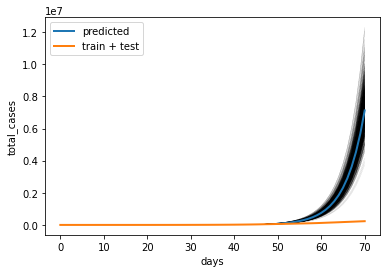

In [33]:
n = 1000
ws = np.random.multivariate_normal(mu, sigma, n)
    
for w in ws:
    plt.plot(X[:, 1], np.exp(X.dot(w)), 'k-', lw=.05)
plt.plot(X_test[:, 1], np.exp(model_total.predict(X_test)), lw=2, label='predicted')
plt.plot(X[:, 1], y_total, label='train + test', lw=2)
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend()
plt.show()

In [34]:
def get_preds_by_date(date, n):
    days = (pd.to_datetime(date) - pd.to_datetime("2020-03-03")).days + 1
    ns = np.random.multivariate_normal(mu, sigma, n)
    preds = np.exp(ns[:, 1] + ns[:, 1] * days)
    plt.hist(preds, bins=20)
    print(f"total on {date} is {int(preds.mean())}")

total on 2020-05-01 is 938152


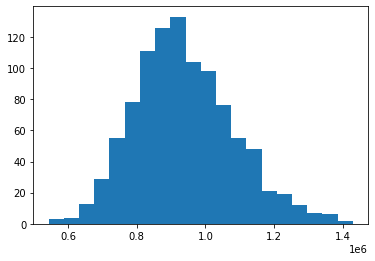

In [35]:
get_preds_by_date("2020-05-01", 1000)

total on 2020-06-01 is 1037668700


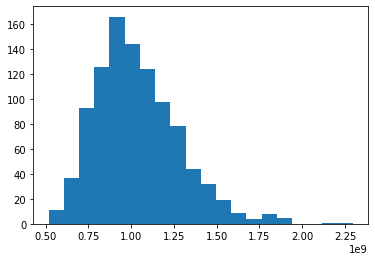

In [36]:
get_preds_by_date("2020-06-01", 1000)

total on 2020-09-01 is 1106376276784614400


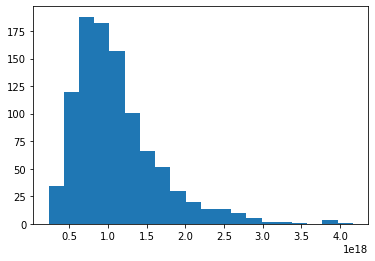

In [37]:
get_preds_by_date("2020-09-01", 1000)

Слишком большие значения: не предсказания, а печалька

### 3.
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\Phi(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x}e^{\frac{-t^2}{2}}dt$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### a.
Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Продифференцируем данную функцию, и будем считать, что $y=e^{ax^2+bx+c}$

тогда $ln(y)=ax^2+bx+c$, а здесь мы уже и линейную регрессию обучить можем

In [38]:
def make_polinom(X):
    return np.stack([np.ones(X.shape[0]), X[:, 1], X[:, 1] **2], axis=-1)

In [40]:
X = make_polinom(X)
X_train = make_polinom(X_train)
X_test = make_polinom(X_test)

In [41]:
y_train_new_ln = np.log(y_train_new)
y_test_new_ln = np.log(y_test_new)

In [51]:
def alpha_search(X_train, y_train, X_test, y_test):
    alphas = np.linspace(.001, 1, 20)
    best_alpha = 0
    best_train = 1e18
    for alpha in alphas:
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X_train, np.log(y_train))
        train_error = np.sqrt(mean_squared_error(y_train, np.exp(model.predict(X_train))))
        test_error = np.sqrt(mean_squared_error(y_test, np.exp(model.predict(X_test))))
        print(f'alpha = {alpha}, train_error={train_error}, test_error={test_error}')
    
        if best_train > train_error:
            best_train = train_error
            best_alpha = alpha
            
    return best_alpha

In [52]:
best_alpha = alpha_search(X_train, y_train_new, X_test, y_test_new)

alpha = 0.001, train_error=457.5717769782376, test_error=1919.6212492572172
alpha = 0.05357894736842105, train_error=458.9869899617447, test_error=1897.6165053872978
alpha = 0.1061578947368421, train_error=460.3899570700986, test_error=1875.8776459007079
alpha = 0.15873684210526315, train_error=461.7807506777057, test_error=1854.4002557513556
alpha = 0.2113157894736842, train_error=463.15944783010144, test_error=1833.1800268167738
alpha = 0.26389473684210524, train_error=464.5261297923056, test_error=1812.2127550798114
alpha = 0.3164736842105263, train_error=465.8808816306366, test_error=1791.494337899322
alpha = 0.36905263157894735, train_error=467.22379182461304, test_error=1771.0207713809623
alpha = 0.4216315789473684, train_error=468.55495190797797, test_error=1750.7881478281606
alpha = 0.47421052631578947, train_error=469.87445613526575, test_error=1730.7926532905838
alpha = 0.5267894736842105, train_error=471.1824011739445, test_error=1711.0305651824553
alpha = 0.5793684210526315

In [53]:
best_alpha

0.001

In [54]:
model = Ridge(alpha=best_alpha, fit_intercept=False)
model.fit(X_train, y_train_new_ln)

Ridge(alpha=0.001, fit_intercept=False)

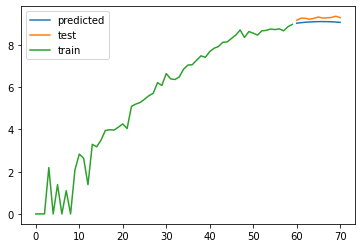

In [55]:
plt.plot(X_test[:, 1], model.predict(X_test), label='predicted')
plt.plot(X_test[:, 1], y_test_new_ln, label='test')
plt.plot(X_train[:, 1], y_train_new_ln, label='train')
plt.legend()
plt.show()

#### b.
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [56]:
noise = np.std(np.array(y_train_new_ln) - model.predict(X_train))
s = noise ** 2 / best_alpha
mu, sigma = get_mu_sigma(X_train, y_train_new_ln, s, noise)
print('mu =', mu)
print('sigma =', sigma)

mu = [-0.50120199  0.29193039 -0.00221661]
sigma = [[ 2.91404554e-02 -1.95879123e-03  2.74340477e-05]
 [-1.95879123e-03  1.78980554e-04 -2.83814483e-06]
 [ 2.74340477e-05 -2.83814483e-06  4.81049146e-08]]


#### c.
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [70]:
def get_total(preds):
    preds = np.exp(preds)
    return np.tril(np.ones((preds.shape[0], preds.shape[0]))).dot(preds)

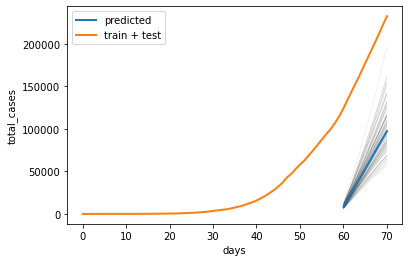

In [88]:
n = 100
ws = np.random.multivariate_normal(mu, sigma, n)
    
for w in ws:
    plt.plot(X_test[:, 1], get_total(X_test.dot(w)), 'k-', lw=.05)
plt.plot(X_test[:, 1], get_total(model.predict(X_test)), lw=2, label='predicted')
plt.plot(X[:, 1], y_total, label='train + test', lw=2)
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend()
plt.show()